In [1]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#disabe annoying warnings
import warnings
warnings.filterwarnings('ignore')

Sources:
- http://webcache.googleusercontent.com/search?q=cache:https://medium.com/mlearning-ai/build-news-recommendation-model-using-python-bert-and-faiss-10ea8c65e6c&sca_esv=585540903&strip=1&vwsrc=0 with notebook https://colab.research.google.com/drive/1uuQaagWNh7gexSQhchpOgGyPKYK2e6SU#scrollTo=ooBElUsT53JO 

- https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb

- Deep Learning Recommendation Model (DLRM) using HugeCTR’s low level python API: https://nvidia-merlin.github.io/HugeCTR/v3.5/notebooks/news-example.html
- https://www.kaggle.com/code/accountstatus/mind-microsoft-news-recommendation-v2#Importing-The-Packages

In [2]:
news_train = 'MINDlarge_train/news.tsv'
news_test = 'MINDlarge_test/news.tsv'
news_valid = 'MINDlarge_val/news.tsv'

#entity_embedding.vec ->	The embeddings of entities in news extracted from knowledge graph 
#relation_embedding.vec	->  The embeddings of relations between entities extracted from knowledge graph
#both [ID (retrievable from news dataset: columns) - EMB VALUES]

In [6]:
def load_news_df(path):
    if 'news' in path:
        columns = ['News ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract",
                "URL",
                "Title Entities",
                "Abstract Entities "]
    
    elif 'behavior' in path:
        columns = ['Impression ID',
                "User ID",
                "Time",
                "History",
                "Impressions"]
    
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    
    return df

#news_df.shape

In [7]:
train = load_news_df(news_train)
test = load_news_df(news_test)
valid = load_news_df(news_valid)
print(train.shape, test.shape, valid.shape)

(101527, 8) (120959, 8) (72023, 8)


# EDA
### news

In [5]:
news_df = load_news_df(news_train)
news_df.shape #consider stratified sampling if need to reduce dataset

(101527, 8)

In [7]:
""" 
#category & subcategory distribution:
news_df['Category'] = news_df['Category'].astype('category')
news_df['SubCategory'] = news_df['SubCategory'].astype('category')

# Drop columns not needed for this operation
columns_to_keep = ['Category', 'SubCategory']
df_reduced = news_df[columns_to_keep]

# Group and unstack
category_counts = df_reduced.groupby(['Category', 'SubCategory']).size().unstack(fill_value=0)

category_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Distribution of Categories and Subcategories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='SubCategory', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

"""

In [34]:
missing_values = news_df.isnull().sum()
missing_values #

News ID                  0
Category                 0
SubCategory              0
Title                    0
Abstract              5415
URL                      0
Title Entities           3
Abstract Entities        6
dtype: int64

In [35]:
#remove rows where 'Title Entities' or 'Abstract Entities' are missing (only 6 samples out of +100k)
news_df = news_df.dropna(subset=['Title Entities', 'Abstract Entities '])
missing_values = news_df.isnull().sum()
missing_values

News ID                  0
Category                 0
SubCategory              0
Title                    0
Abstract              5415
URL                      0
Title Entities           0
Abstract Entities        0
dtype: int64

In [36]:
#display an example with missing abstract
sample = news_df[news_df['Abstract'].isnull()].iloc[6]
sample #the url does not lead to anything

News ID                                                          N83188
Category                                                         sports
SubCategory                                                football_nfl
Title                 Colts News: Chris Ballard on first half of sea...
Abstract                                                            NaN
URL                       https://assets.msn.com/labs/mind/AAJWD7n.html
Title Entities        [{"Label": "Indianapolis Colts", "Type": "O", ...
Abstract Entities                                                    []
Name: 83, dtype: object

<AxesSubplot: >

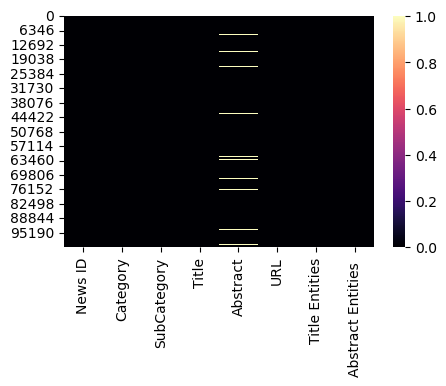

In [46]:
plt.figure(figsize=(5,3))
sns.heatmap(news_df.isnull(), cbar=True, cmap='magma')

In [6]:
news_df = news_df.drop(columns=['URL'])
news_df = news_df.dropna()
news_df.shape


(96106, 7)

In [10]:
unique_categories = news_df['Category'].unique()
unique_subcategories = news_df['SubCategory'].unique()

#print("Categories:", unique_categories)
#print("Subcategories:", unique_subcategories)


list_of_categories = unique_categories.tolist()
list_of_subcategories = unique_subcategories.tolist()
len(list_of_subcategories) 


280

In [12]:
set(list_of_categories).intersection(set(list_of_subcategories))

{'foodanddrink',
 'games',
 'lifestyle',
 'news',
 'sports',
 'travel',
 'tv',
 'video'}

____________________________________________________
## behaviours

behaviors.tsv:<br> This file records user interactions with news articles. It typically includes user IDs, the time of interaction, the history of news interactions for each user, and the news articles they have clicked on.

`ImpressionID, UserID, Time, History, Impressions` <br>
`1, U1, 11/01/2020 11:30, N1 N2 N3, N4-0 N5-1 N6-0`


ImpressionID: "1" is the unique identifier for this impression.<br>
UserID: "U1" denotes the user.<br>
Time: "11/01/2020 11:30" is the timestamp of the interaction.<br>
History: "N1 N2 N3" are IDs of news articles the user has clicked on before.<br>
Impressions: "N4-0 N5-1 N6-0" shows that articles "N4" and "N6" were not clicked (indicated by "-0"), while "N5" was clicked (indicated by "-1") during this impression.

In [39]:
#look at behaviours.tsv file
behaviours_path = 'MINDlarge_train/behaviors.tsv'

behaviours_df = pd.read_csv(behaviours_path,header=None,sep='\t')
behaviours_df.columns=['Impression ID',
                'User ID',
                "Time of interaction",
                "History",
                "News clicked",
                ]
behaviours_df.head() #15 seconds t load!

,Impression ID,User ID,Time of interaction,History,News clicked
0,1,U87243,11/10/2019 11:30:54 AM,N8668 N39081 N65259 N79529 N73408 N43615 N2937...,N78206-0 N26368-0 N7578-0 N58592-0 N19858-0 N5...
1,2,U598644,11/12/2019 1:45:29 PM,N56056 N8726 N70353 N67998 N83823 N111108 N107...,N47996-0 N82719-0 N117066-0 N8491-0 N123784-0 ...
2,3,U532401,11/13/2019 11:23:03 AM,N128643 N87446 N122948 N9375 N82348 N129412 N5...,N103852-0 N53474-0 N127836-0 N47925-1
3,4,U593596,11/12/2019 12:24:09 PM,N31043 N39592 N4104 N8223 N114581 N92747 N1207...,N38902-0 N76434-0 N71593-0 N100073-0 N108736-0...
4,5,U239687,11/14/2019 8:03:01 PM,N65250 N122359 N71723 N53796 N41663 N41484 N11...,N76209-0 N48841-0 N67937-0 N62235-0 N6307-0 N3...


____________________________________________________

In [40]:
missing_values = behaviours_df.isnull().sum()
missing_values #almost half!!!!

Impression ID              0
User ID                    0
Time of interaction        0
History                46065
News clicked               0
dtype: int64

In [57]:
unique_users = behaviours_df['User ID'].nunique()
unique_news = news_df['News ID'].nunique()
print(f"Unique users: {unique_users}, Unique news articles: {unique_news}")

Unique users: 711222, Unique news articles: 96106


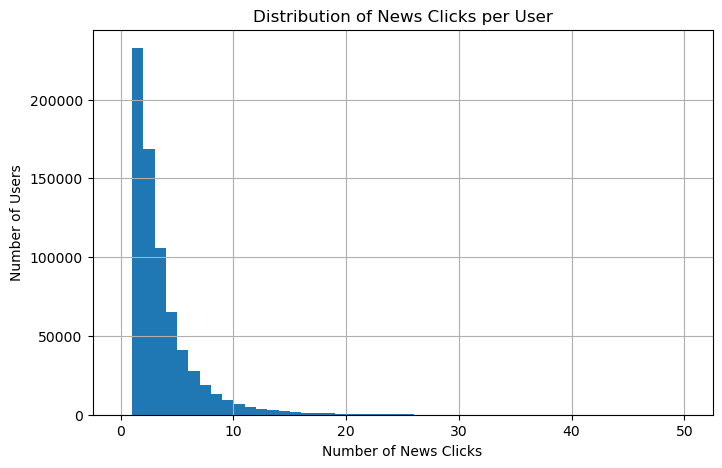

In [53]:
news_clicks_per_user = behaviours_df['User ID'].value_counts()

plt.figure(figsize=(8, 5))
news_clicks_per_user.hist(bins=50, range=(0,50)) 
plt.title('Distribution of News Clicks per User')
plt.xlabel('Number of News Clicks')
plt.ylabel('Number of Users')
plt.show()




In [51]:
behaviours_df['Time of interaction'] = pd.to_datetime(behaviours_df['Time of interaction'])
behaviours_df['Date'] = behaviours_df['Time of interaction'].dt.date
interactions_per_day = behaviours_df['Date'].value_counts().sort_index()

In [ ]:
plt.figure(figsize=(12, 6))
interactions_per_day.plot(kind='line')
plt.title('Frequency of User Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.show()